<a href="https://colab.research.google.com/github/HammoutiD/NLP/blob/main/5_training_HAMMOUTI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HAMMOUTI Douae

For this notebook a GPU environment is recomended, you could use the Nvidia T4 GPU provided by the Google Colab free plan; keep in mind terms of service and limitations though.


The second part of this notebook is based on Patrick von Platen's tutorial on HuggingFace and EPFL materials.

## Image captioning

In this first part we will experiment with something a little bit different, moving beyond NLP and tryining to build Visual Language Models. The goal indeed is to automatically produce image captions. Similar to a sequence-to-sequence machine translation architectures, we will rely on a encoder-decoder model to 1) encode the image and 2) generate the caption. This time, though, we have multi-modal data: images on one side and texts on the other. These two sources of information will be combined by cross-attention mechanism inside the decoder.

Once the model is trained we can generate the textual description and visualize the attention weights. Let's begin!



In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from collections import Counter
from tqdm import tqdm

import torch
from torch import Tensor
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from itertools import chain

We use the Flickr 8k Dataset, a popular dataset containing 8k images (taken from Flickr) with 5 captions each.

WARNING: the dataset size is 1.04G

In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

PATH = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", PATH)

Using Colab cache for faster access to the 'flickr8k' dataset.
Path to dataset files: /kaggle/input/flickr8k


In the downloaded folder you will see `captions.txt`, the collection of captions and the corresponding image filenames, and a `Ìmages` subfolder containing the jpg images.

Let's load the `captions.txt` file first:

In [ ]:
data = pd.read_csv(os.path.join(PATH, 'captions.txt'), sep=',', header=0)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In the 'image' column we only have the image filename, that's why we need to concatenate PATH and the filename to be able to retrieve the image.

We also need to tokenize the text in the column 'caption' to get the tokens.

In [ ]:
data['image'] = data['image'].apply(lambda x: os.path.join(PATH, 'Images', x))

# Your code here
# create a new column 'tokens' containing lowercased tokens from the caption
data['tokens'] = data['caption'].apply(lambda x: x.lower().split())



assert(data['tokens'][0][:6] == ['a','child','in','a','pink','dress'])

For simplicity we will limit the dataset by reducing the number of captions, keeping only a single caption for each image

In [ ]:
images = [x for i, x in enumerate(data['image']) if i % 5 == 0]
sentences = [x for i, x in enumerate(data['tokens']) if i % 5 == 0]

Being this a very close-ended generation task, we will derive our (small) vocabulary directly from the dataset by considering only words that appear at least 5 times.

With the `token2index` we can convert tokens (words) into indeces, and the way back with `index2token`

In [ ]:
class Vocab:
    def __init__(self, dataset):
        self.word_freq = Counter()
        for tokens in dataset:
            self.word_freq.update(tokens)

        words = [word for word in self.word_freq.keys() if self.word_freq[word] >= 5]
        self.token2index = {word: idx for idx, word in enumerate(words, 4)}
        self.token2index['<pad>'] = 0
        self.token2index['<start>'] = 1
        self.token2index['<eos>'] = 2
        self.token2index['<unk>'] = 3
        self.index2token = {value: word for word, value in self.token2index.items()}
        self.vocab_size = len(self.index2token)

    def __len__(self):
        return self.vocab_size

vocab = Vocab(sentences)
len(vocab)

1205

We limit the sequence length to 50, truncating or padding the input if needed

In the following code we add the special token `<start>` at the beginning of the sentence and `<eos>` at the end, `<unk>` is used to represent words not included in the dictionary (vocabulary)

In [ ]:
MAX_LEN = 50

captions = []
for sent in sentences:
    sent = sent[:MAX_LEN-2]
    toks = [vocab.token2index['<start>']] + \
            [vocab.token2index.get(x, vocab.token2index['<unk>']) for x in sent] + \
            [vocab.token2index['<eos>']] + \
            [vocab.token2index['<pad>']] * (MAX_LEN-2 - len(sent))
    captions.append(toks)

We can finally split the preprocessed dataset into train, validation and test set

In [ ]:
train_images = images[:-300]
train_captions = captions[:-300]

eval_images = images[-300:-100]
eval_captions = captions[-300:-100]

test_images = images[-100:]
test_captions = captions[-100:]

print('Training set ',len(train_images))
print('Validation set ',len(eval_images))
print('Test set ',len(test_images))

Training set  7791
Validation set  200
Test set  100


And finally create our customized dataset.

With this code we convert RGB images into Tensors and apply normalization. For the textual part instead we convert tokens into Long Tensors, create the padding mask and the labels used for the decoder training. In this case the labels will just be a copy of the input text, in which we replace padded tokens with -100 (they will be ignored by the loss function).

In [ ]:
transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

class CaptionDataset(Dataset):
    def __init__(self, images, captions, transform=None):
        self.images = images
        self.captions = captions
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        img = np.array(img)
        img = cv2.resize(img, (256, 256))

        assert img.shape == (256, 256, 3)
        assert np.max(img) <= 255.

        img = torch.FloatTensor(img / 255.)
        img = img.permute(2, 0, 1)  # 3, H, W

        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[idx])

        mask = caption == 0

        labels = caption.clone() * ~mask
        labels += torch.tensor([-100], dtype=torch.long) * mask

        return img, caption, labels, mask

train_dataset = CaptionDataset(train_images, train_captions, transform)
eval_dataset = CaptionDataset(eval_images, eval_captions, transform)
test_dataset = CaptionDataset(test_images, test_captions, transform)

Let's see an example

<start> a child holding up a sign with a <unk> and <unk> . <eos>


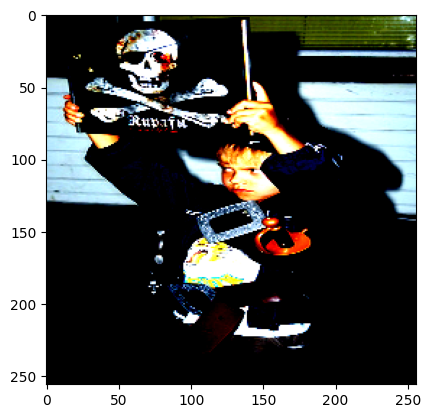

In [ ]:
def decode_caption(tokens, vocab):
    dec_caption = [vocab.index2token[x] for x in tokens.numpy() if x != 0]
    return " ".join(dec_caption)

for image, caption, _, _ in eval_dataset:
    print(decode_caption(caption, vocab))
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
    break

Clearly the normalized image is not visualized correctly because of the invalid values range. The caption instead is encapsulated between `<start>` and `<eos>` with `<unk>` replacing rare words.

Let's create a configuration class for our model and set other hyper-parameters

In [ ]:
class Config:
    embd_pdrop = 0.2
    resid_pdrop = 0.2
    attn_pdrop = 0.2
    head_pdrop = 0.2
    n_layer = 6
    n_head = 8
    n_embd = 1024
    max_len = MAX_LEN

    def __init__(self, vocab_size):
        setattr(self, 'vocab_size', vocab_size)

config = Config(len(vocab))

BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 4

Now we can create our data loaders, please notice the batch size for the test set to 1, since at inference time we will generate captions one by one.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False, pin_memory=True)

It's time now to start implementing the model architecture, in particular the image encoder.

For this purpose, we rely on a pre-trained ResNet-50 model, finetuning only a subset of layers (if needed)

The encoder will convert the (N, 3, H, W) RGB image into a (N, 14x14, 2048) tensor, where N is the batch size and 2048 the feature dimension

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, enc_image_size=14):
        super(ImageEncoder, self).__init__()
        self.enc_image_size = enc_image_size

        # pretrained ImageNet ResNet-50
        resnet = torchvision.models.resnet50(pretrained=True)

        # remove linear and pool layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # resize image to fixed size using adaptive pool to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((enc_image_size, enc_image_size))
        self.fine_tune()

    def fine_tune(self):
        for param in self.resnet.parameters():
            param.requires_grad = False

        # if fine-tuning, fine-tune only convolutional blocks 2 through 4
        for child in list(self.resnet.children())[5:]:
            for param in child.parameters():
                param.requires_grad = True

    def forward(self, images):
        out = self.resnet(images)
        out = self.adaptive_pool(out)  # N, 2048, 14, 14

        batch, channel = out.size(0), out.size(1)
        out = out.view(batch, channel, -1).permute(0, 2, 1)  # N, 14x14, 2048
        return out

Now the decoder and in particular its block.

Differently from the Transformer encoder, this time we need to 1) apply casual masking to prevent the attention to look at future tokens and 2) add a cross-attention mechanism to combine images and texts

Look at the official documentation to complete this exercise [https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)

In [ ]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.norm1 = nn.LayerNorm(config.n_embd)
        self.norm2 = nn.LayerNorm(config.n_embd)

        self.self_attn = nn.MultiheadAttention(config.n_embd, config.n_head, batch_first=True)
        self.self_attn_drop = nn.Dropout(config.attn_pdrop)
        self.cross_attn = nn.MultiheadAttention(config.n_embd, config.n_head, kdim=2048, vdim=2048, batch_first=True)
        self.cross_attn_drop = nn.Dropout(config.attn_pdrop)

        self.linear1 = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.linear_drop = nn.Dropout(config.resid_pdrop)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(4 * config.n_embd, config.n_embd)
        self.linear_drop2 = nn.Dropout(config.resid_pdrop)

    def forward(self, x, mem, att_msk, pad_mask):
        x = self.norm1(x + self._sa_block(x, att_msk, pad_mask))

        enc_att, att_weight = self._mha_block(x, mem)
        x = self.norm1(x + enc_att)

        x = self.norm2(x + self._ff_block(x))
        return x, att_weight

    def _sa_block(self, x, att_mask, pad_mask):
        '''
        self-attention
        '''

        # Your code here
        # call self_attn with the correct parameters, keeping in mind that it's a self-attention
        # don't forget to use att_mask and pad_mask as well as setting is_casual to True
        attn_output, _ = self.self_attn(query=x, key=x, value=x, attn_mask=att_mask, key_padding_mask=pad_mask, need_weights=False)
        x = attn_output


        return self.self_attn_drop(x)

    def _mha_block(self, x, mem):
        '''
        cross-attention
        '''

        # Your code here
        # call cross_attn with the correct parameters, using the textual representation as query
        # please return the attention weights (att_weight), too
        attn_output, att_weight = self.cross_attn(query=x, key=mem, value=mem, need_weights=True)
        x = attn_output


        return self.cross_attn_drop(x), att_weight

    def _ff_block(self, x: Tensor) -> Tensor:
        '''
        Feed forward network
        '''

        x = self.linear2(self.linear_drop(self.activation(self.linear1(x))))
        return self.linear_drop2(x)

**Why do we need to specify `kdim` and `vdim` instead of relying on the deault values (`dim=embed_dim`)?**

Self-attention: query = key = value → default is fine.

Cross-attention: query (text) ≠ key/value (image) → must set kdim and vdim. **texte en gras**

In this block we assumed that we already have the casual attention mask to prevent the attention to see future tokens in the sequence, it's time now to create this mask

As we have seen, when applying casual attention, we prevent the tokens to attend to the future tokens in the sequence, only looking at previous ones.
We can paralelize the computation by creating a triangual table like this:

<table >
<tr><td>THIS<td><td><td><tr>
<tr><td>THIS<td>IS<td><td><tr>
<tr><td>THIS<td>IS<td>A<td><tr>
<tr><td>THIS<td>IS<td>A<td>TEST<tr>
<table>

and the corresponding attention mask:

<table >
<tr><td>0<td>1<td>1<td>1<tr>
<tr><td>0<td>0<td>1<td>1<tr>
<tr><td>0<td>0<td>0<td>1<tr>
<tr><td>0<td>0<td>0<td>0<tr>
<table>

in which ones represent (masked) positions that we should ignore when computing the attention

Let's start with an example

In [ ]:
H, W = 4, 4

# Your code here
# 1) create a HxW triangual matrix like in the example
# 2) convert the matrix into a boolean matrix (True = masked token)
mask = torch.triu(torch.ones(H, W), diagonal=1).bool()


print(mask)
assert(torch.equal(mask,torch.tensor([[False,  True,  True,  True],[False, False,  True,  True],[False, False, False,  True],[False, False, False, False]])))

tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])


We now have everything we need for the Decoder

One last thing though! Instead of a classification head, this time we need a language model head on which we can then compute the probability on the vocabulary. Rather than having few classes, we want to predict each word in the vocabulary, meaning that we need a final tensor with shape (L, N, V), where L is the sequence lenght, N the batch size and V the vocabulary size.

Let's project the (L, N, E) embedding (with E the embedding size) into (L, N, V) with a Linear layer without bias

In [ ]:
# Your code here
# create the language model head with a linear layer without the bias term
# use config to get the correct parameters for the network

lm_head =  nn.Linear(config.n_embd, config.vocab_size, bias=False)


test = torch.rand(100, 4, 1024)
out = lm_head(test)
assert(tuple(out.shape) == (100, 4, 1205))
assert('bias' not in {x for x, _ in lm_head.named_parameters()})

In [ ]:
class Decoder(nn.Module):
    def __init__(self, config):
        super(Decoder, self).__init__()
        # Your code here
        # instantiate the embedding layer for converting input tokens into embedding vectors
        # Hint: same as the Transformer encoder model
        self.emb =  nn.Embedding(config.vocab_size, config.n_embd)

        # Your code here
        # instantiate the positional embedding layer
        # Hint: same as the Transformer encoder model
        self.pos_emb = nn.Embedding(512, config.n_embd)

        self.norm_emb = nn.LayerNorm(config.n_embd)
        self.drop_emb = nn.Dropout(config.embd_pdrop)

        self.blocks = nn.ModuleList(Block(config) for _ in range(config.n_layer))

        # Your code here
        # add your language model head
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.drop_head = nn.Dropout(config.head_pdrop)

        self._init_weights()

    def _init_weights(self):
        self.emb.weight.data.uniform_(-0.1, 0.1)
        self.lm_head.weight.data.uniform_(-0.1, 0.1)

    def forward(self, input_ids, img, pad_msk):
        device = input_ids.device

        # Your code here
        # create the boolean attention mask with LxL shape (where L is the input sequence lenght)
        # don't forget to load it on the same device as the data and the model!
        # Hint: take the correct dimension directly from the input_ids shape

        mask = torch.zeros((input_ids.size(1), input_ids.size(1)), dtype=torch.bool).to(device)

        x = self.emb(input_ids)  # N, L, E
        position_ids = torch.arange(x.size(1), dtype=torch.long).unsqueeze(0).to(device)  # 1, L
        pos_emb = self.pos_emb(position_ids)  # 1, L, E
        x = x + pos_emb  # N, L, E
        x = self.drop_emb(self.norm_emb(x))

        for block in self.blocks:
            x, att_weights = block(x, img, mask, pad_msk)

        lm_logits = self.lm_head(self.drop_head(x))  # L, N, V
        return lm_logits, att_weights

We are finally ready to initialize the model, optimizer and loss

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

encoder = ImageEncoder()
encoder = encoder.to(device)

decoder = Decoder(config)
decoder = decoder.to(device)

params = chain(encoder.parameters(), decoder.parameters())
optim = AdamW([x for x in params if x.requires_grad], lr=LR)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


**In your opinion, why are we using the `chain` function in this code?**

**We use chain to combine the parameters of the encoder and decoder into a single iterator so the optimizer can update all trainable weights at once.**

**Is the condition `if x.requires_grad` really necessary in this case? What do you expect if we remove it?**

Yes, it is necessary in this case.
Keep it to avoid updating frozen parameters and save computation. **texte en gras**



We train our model by comparing the generated sequence with the true label by shifting it, that is:
<table>
<tr><td>LABEL<td><td>this<td>is<td>a<td>...<tr>
<tr><td>OUTPUT<td>this<td>is<td>a<td>test<td>...<tr>
<table>


In other words, we always predict the next word in the sequence, therefore to check if the prediction if correct or not it's sufficient to create a shifted copy of the input. Keep in mind, indeed, that until now `labels`was just a clone of the input tokens, we now need to flatten the representation (taking every sequence inside the batch) and apply the shift

The loss will be a simple cross entropy betweend predictions and labels

Here our training and validation loops:

In [ ]:
def train(data_loader, encoder, decoder, optimizer, criterion, device):
    encoder = encoder.train()
    decoder = decoder.train()
    loss_epoch = 0

    for img, cap, lab, msk in tqdm(data_loader):
        img = img.to(device)
        cap = cap.to(device)
        lab = lab.to(device)
        msk = msk.to(device)
        enc_img = encoder(img)
        lm_logits, _ = decoder(cap, enc_img, msk)

        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_logits = shift_logits.view(-1, shift_logits.size(-1))
        shift_labels = lab[..., 1:].contiguous()
        shift_labels = shift_labels.view(-1)
        loss = criterion(shift_logits, shift_labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_epoch += loss.item()

    return loss_epoch / len(data_loader)


def validate(data_loader, encoder, decoder, criterion, device):
    encoder = encoder.eval()
    decoder = decoder.eval()
    loss_epoch = 0

    with torch.no_grad():
        for img, cap, lab, msk in tqdm(data_loader):
            img = img.to(device)
            cap = cap.to(device)
            lab = lab.to(device)
            msk = msk.to(device)
            enc_img = encoder(img)
            lm_logits, _ = decoder(cap, enc_img, msk)

            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_logits = shift_logits.view(-1, shift_logits.size(-1))
            shift_labels = lab[..., 1:].contiguous()
            shift_labels = shift_labels.view(-1)
            loss = criterion(shift_logits, shift_labels)
            loss_epoch += loss.item()

    return loss_epoch / len(data_loader)

Finally we can launch the training, but it could take a while: around 4 min per epoch

In [ ]:
train_loss, valid_loss = [], []
least_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch + 1} of {EPOCHS}")
    train_epoch_loss = train(train_loader, encoder, decoder, optim, criterion, device)
    valid_epoch_loss = validate(eval_loader, encoder, decoder, criterion, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Training loss: {train_epoch_loss}")
    print(f"Validation loss: {valid_epoch_loss}")
    print('-' * 50)

[INFO]: Epoch 1 of 4


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Training loss: 5.32586178623262
Validation loss: 3.848334014415741
--------------------------------------------------
[INFO]: Epoch 2 of 4


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Training loss: 3.969925051829854
Validation loss: 3.5969148874282837
--------------------------------------------------
[INFO]: Epoch 3 of 4


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Training loss: 3.567854521704502
Validation loss: 3.108691990375519
--------------------------------------------------
[INFO]: Epoch 4 of 4


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

Training loss: 2.862819233878714
Validation loss: 2.7633621096611023
--------------------------------------------------


Let's plot the loss

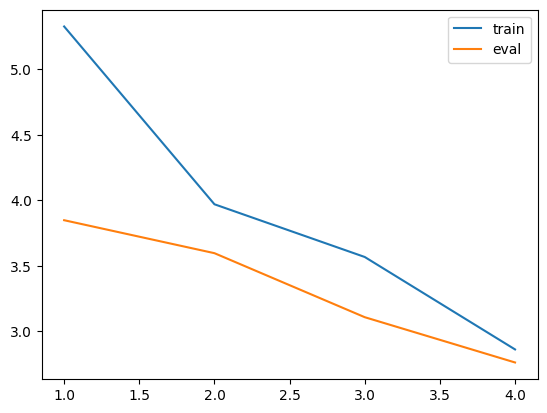

In [ ]:
x = [x for x in range(1, EPOCHS + 1)]
plt.plot(x, train_loss, label="train")
plt.plot(x, valid_loss, label="eval")
plt.legend()
plt.show()

Now that the model is trained, let's try to use it for inference, that is generating new captions on the test set.

We start with an empy sentence (with only the `<start>` token) and greedly select the most probable next word at every step, terminating when we generate the `<eos>` terminal token, or when we reach the `MAX_LEN` sequence lenght.

In [ ]:
encoder.eval()
decoder.eval()
with torch.no_grad():
    for img, _, _, _ in tqdm(test_loader):
        img = img.to(device)
        enc_img = encoder(img)

        # Your code here
        # create a Tensor containing the token index corresponding to <start>
        # the tensor, with Long type, should have shape (1, S), where 1 is the batch size and S the sequence lenght (1 in this case)
        # keep in mind the tensor must be loaded into the same device of the model
        input_ids = torch.tensor([[vocab.token2index['<start>']]], dtype=torch.long).to(device)

        for _ in range(config.max_len):
            lm_logits, att_weights = decoder(input_ids, enc_img, None)

            # lm_logits shape is (1, S, V) with S the sequence length and V the vocabulary size
            next_item = lm_logits[0, -1].topk(1)[1] # get the top-1 probability (most probable next word)
            next_item = next_item.unsqueeze(0) # (1, 1) # Added this line back

            # Your code here
            # keep generating the sequence by concatenating the predicted word to the input sequence (overwriting input_ids)
            input_ids = torch.cat((input_ids, next_item), dim=1)

            # check is the predicted token is the end of the sequence
            if next_item.item() == vocab.token2index['<eos>']:
                break

        tokens = input_ids[0].cpu().tolist()

        # Your code here
        # 1. convert the list of token indeces into token strings using the vocabulary
        # 2. join the tokens to form a sentence and print the result
        sentence = " ".join([vocab.index2token[idx] for idx in tokens])

        print(sentence)
        break

  0%|          | 0/200 [00:00<?, ?it/s]

<start> on <eos>


We can also plot the attention weights returned by the decoder and the original image, we can use the following function to reverse the normalization process

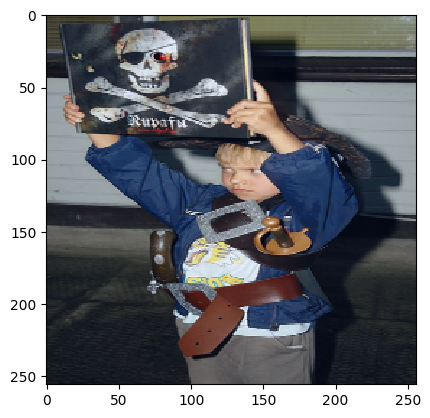

In [ ]:
def unormalize(tensor, mean=None, std=None):
    if mean is not None and std is not None:
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return torch.clip(tensor, min=0, max=1)

    b, c, h, w = tensor.shape
    tensor = tensor.view(b, -1)
    tensor -= tensor.min(1, keepdim=True)[0]
    tensor /= tensor.max(1, keepdim=True)[0]
    return tensor.view(b, c, h, w)

img = unormalize(img)[0].permute(1, 2, 0).cpu()  # 256, 256, 3
plt.imshow(img, interpolation='nearest')

Let's put everything together and run our inference

  0%|          | 0/200 [00:00<?, ?it/s]

<start> on <eos>


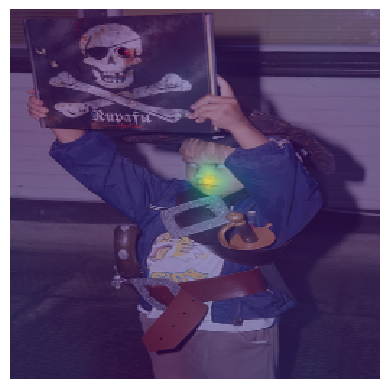

  0%|          | 0/200 [00:00<?, ?it/s]


In [ ]:
encoder.eval()
decoder.eval()
with torch.no_grad():
    for img, _, _, _ in tqdm(test_loader):
        img = img.to(device)
        enc_img = encoder(img)

        # initialize input with <start> token
        input_ids = torch.tensor([[vocab.token2index['<start>']]], dtype=torch.long).to(device)

        # generate sequence
        for _ in range(config.max_len):
            lm_logits, att_weights = decoder(input_ids, enc_img, None)

            # get the most probable next token
            next_item = lm_logits[0, -1].topk(1)[1]  # shape: (1,)
            next_item = next_item.unsqueeze(0)       # shape: (1,1)

            # append predicted token to input sequence
            input_ids = torch.cat((input_ids, next_item), dim=1)  # now shapes match

            # stop if <eos> is predicted
            if next_item.item() == vocab.token2index['<eos>']:
                break

        # convert token ids to words
        tokens = input_ids[0].cpu().tolist()
        sentence = " ".join([vocab.index2token[idx] for idx in tokens])
        print(sentence)

        # unnormalize the image
        img_vis = unormalize(img)[0].permute(1, 2, 0).cpu()  # (H,W,C)

        # resize and prepare attention map
        att = att_weights[0].reshape(-1, 14, 14).cpu()       # (num_tokens,14,14)
        att = torch.sum(att, 0) / att.shape[0]              # average over tokens
        att = T.Resize(size=(img_vis.shape[0], img_vis.shape[1]))(att.unsqueeze(0))
        att = att.squeeze(0)

        # plot image with attention overlay
        plt.imshow(img_vis, interpolation='nearest')
        plt.imshow(att, interpolation='bilinear', alpha=0.5)
        plt.axis('off')
        plt.show()
        plt.close()
        break  # only show first test image


Besides the predicted caption we plot here the attention weights from the last layer superimposed on the original image.

Despite few epochs and a small architecture, the model seems to be able to describe to some extent the images, focusing the attention where it's most needed.

## Text generation tutorial

In the previous task we trained our custom decoder from scratch, using a very small and close-ended vocabulary. We now want to use more powerfull pre-trained models to generate open-ended sentences.

For this purpose we rely on the HuggingFace library, loading the pre-trained GPT-2 model freely available on the platform.  

First, we import the pretrained GPT-2 and a finetuned version of it with [huggingface](https://huggingface.co/)'s [transformers package](https://huggingface.co/docs/transformers/index). The latter is fine-tuned on sample of BookCorpus dataset for short story generation. This model has been fine-tuned to first take the `<BOS>` token and then a token that depicts the genre we desire to generate such as `<adventure>`. Possible genres this model handles and their respective tokens are:

- Romance `<romance>`
- Adventure `<adventure>`
- Mystery & detective `<mystery-&-detective`
- Fantasy `<fantasy>`
- Humor & comedy `<humor-&-comedy>`
- Paranormal `<paranormal>`
- Science fiction `<science-fiction>`

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the relevant models and their respective tokenizers
pretrained_model_id = "gpt2"
story_model_id = "pranavpsv/genre-story-generator-v2"

pretrained_tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_id)
story_tokenizer = GPT2Tokenizer.from_pretrained(story_model_id)

pretrained_model = GPT2LMHeadModel.from_pretrained(pretrained_model_id , pad_token_id=pretrained_tokenizer.eos_token_id)
story_model = GPT2LMHeadModel.from_pretrained(story_model_id, pad_token_id=story_tokenizer.eos_token_id)

pretrained_model = pretrained_model.eval().to(device)
story_model = story_model.eval().to(device)

# Display function to compare the pretrained and story-finetuned GPT-2 model generations
def display_outputs(pretrained_output, story_output, multiple_output=False):
    if not multiple_output:
        print(80 * '-')
        print("Pretrained model output:")
        print(80 * '-')
        print(pretrained_tokenizer.decode(pretrained_output[0], skip_special_tokens=True))
        print(80 * '-')
        print("Story model output:")
        print(80 * '-')
        print(story_tokenizer.decode(story_output[0], skip_special_tokens=True))
    else:
        print(80 * '-')
        print("Pretrained model output:")
        print(80 * '-')
        for i, beam_output in enumerate(pretrained_output):
            if i > 0:
                print(20 * '-')
            print("{}: {}".format(i + 1, pretrained_tokenizer.decode(beam_output, skip_special_tokens=True)))

        print(80 * '-')
        print("Story model output:")
        print(80 * '-')
        for i, beam_output in enumerate(story_output):
            if i > 0:
                print(20 * '-')
            print("{}: {}".format(i + 1, story_tokenizer.decode(beam_output, skip_special_tokens=True)))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/203 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

### Greedy Search

Greedy search is the first type of decoding algorithm one can imagine: we select the next token as the one with the highest probability.
Given the following image provided by Patrick von Platen, the path that a greedy search would choose is depicted by the red path.

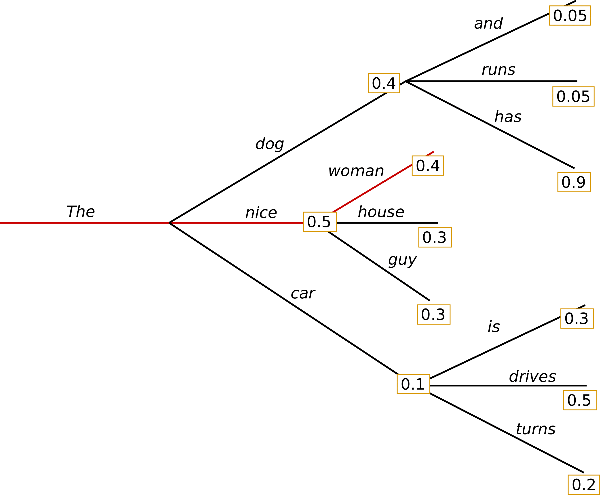

Given the word **The**, the algorithm picks *greedily* the highest probability token **nice**, and then **woman**. Note that the generated token sequence has therefore a probability of:

$0.5 \times 0.4 = 0.2$.

Now let's generate a sequence after inputting the model the sequence **"Bella couldn't take it anymore. Edward was gone for 3 months now and"** inspired by second movie and book of Twilight. For the story generation version we will add the prefix token `<romance>`.

Note that in *transformers*, we can generate with autoregressive models simply by calling the model's *generate* function and giving it tokenized inputs as shown below:

In [ ]:
# Tokenize the text with which we condition the generation
pretrained_input_ids = pretrained_tokenizer.encode("Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')
story_input_ids = story_tokenizer.encode("<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')

# Generate text until the output length (which includes the context length) reaches max_length
greedy_pretrained_output = pretrained_model.generate(pretrained_input_ids.to(device), max_length=100)
greedy_story_output = story_model.generate(story_input_ids.to(device), max_length=100)

# Decode the output back into readable strings
display_outputs(greedy_pretrained_output, greedy_story_output)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


--------------------------------------------------------------------------------
Pretrained model output:
--------------------------------------------------------------------------------
Bella couldn't take it anymore. Edward was gone for 3 months now and Bella was still in the hospital.

"I'm so sorry, Bella," Edward said. "I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so
--------------------------------------------------------------------------------
Story model output:
--------------------------------------------------------------------------------
<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and Bella was still in love with him. Bella wanted to be with Edward but she couldn't. Bella wanted to be with Edward but she couldn't. Bella wanted to be with Edward but she couldn't. Bella wanted to be with Edward but she couldn't. Bella w

:**What is a serious problem you find about the greedy search algorithm? Why do you think this might be happening?**

Greedy search always picks the most probable next token, which can cause repetitive, stuck, or boring sequences because it ignores less likely but more diverse options. This explains why your output repeats phrases like “Bella wanted to be with Edward but she couldn’t”.




**Is there a difference between the pretrained model and the story finetuned model with respect to these pitfalls?**

Yes. The story-finetuned model tends to repeat phrases even more because it has learned patterns from its fine-tuning dataset, which may contain repetitive or formulaic storytelling. The pretrained model can also repeat, but usually less systematically, since it was trained on more diverse text.

### Beam Search

Instead of considering a single best next token, the beam search algorithm tries to respond to problems with greedy search by considering the next *num_beam* amount of tokens that have the highest joint probability. Consider the initial token sequence probability tree illustration with *num_beams*=2 (since *num_beams*=1 would be greedy decoding!):

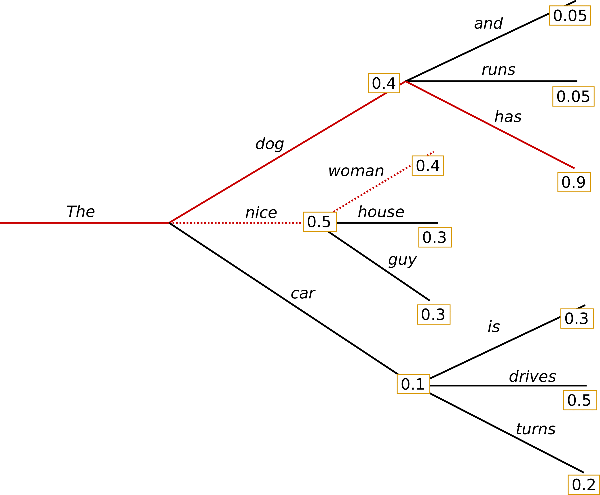

- In the first step t=0, **The nice** seems to have the highest probability, so the model chooses **The**
- In the next time step t=1, we notice that the joint probability of **The dog has** ($0.4 \times 0.9 = 0.36$) is higher than **The nice woman**'s ($0.5 \times 0.4 = 0.2$)

$\implies$ therefore the model eventualy picks the red branch sequence **The dog has**

Let's generate what beam search would give for the same input sentence **"Bella couldn't take it anymore. Edward was gone for 3 months now and"**.

We also do *early_stopping*=True, which means that we stop generating if the token is the end-of-sentence [EOS] token.

Check the documentation for more info [https://huggingface.co/docs/transformers/v4.46.3/en/main_classes/text_generation#transformers.GenerationMixin.generate](https://huggingface.co/docs/transformers/v4.46.3/en/main_classes/text_generation#transformers.GenerationMixin.generate) and in particular the configurations [https://huggingface.co/docs/transformers/v4.46.3/en/main_classes/text_generation#transformers.GenerationConfig](https://huggingface.co/docs/transformers/v4.46.3/en/main_classes/text_generation#transformers.GenerationConfig)

In [ ]:
# Tokenize the text with which we condition the generation
pretrained_input_ids = pretrained_tokenizer.encode("Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')
story_input_ids = story_tokenizer.encode("<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')

# Generate text until the output length (which includes the context length) reaches max_length or early stopping
beam_pretrained_output = pretrained_model.generate(
    pretrained_input_ids.to(device),
    max_length=100,
    num_beams=4, # set num_beams=4, default num_beams=1
    early_stopping=True
)

beam_story_output = story_model.generate(
    story_input_ids.to(device),
    max_length=100,
    num_beams=4, # set num_beams=4, default num_beams=1
    early_stopping=True
)

# Decode the output back into readable strings
display_outputs(beam_pretrained_output, beam_story_output)

--------------------------------------------------------------------------------
Pretrained model output:
--------------------------------------------------------------------------------
Bella couldn't take it anymore. Edward was gone for 3 months now and Bella had no idea what was going on.

"I'm sorry, Bella," Edward said.

"I'm sorry," Bella said.

"I'm sorry," Edward said.

"I'm sorry," Bella said.

"I'm sorry," Edward said.

"I'm sorry," Bella said.

"I'm sorry," Edward said.

"
--------------------------------------------------------------------------------
Story model output:
--------------------------------------------------------------------------------
<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and Bella couldn't take it anymore. Bella wanted to be with Edward, but she couldn't take it anymore. Bella wanted to be with Edward, but she couldn't take it anymore. Bella wanted to be with Edward, but she couldn't take it anymore. Bella wanted to be w

**Is there still a difference between the pretrained model and the story finetuned model with respect to these pitfalls?**

Pretrained model: The repetition is present but less systematic and more context-dependent. It sometimes repeats short phrases or dialogue lines.

Story-finetuned model: The repetition is much more pronounced and structured, often repeating entire clauses or sentences. This happens because the fine-tuning dataset likely contained repeated narrative patterns, which the model has learned and overfits to.

A possible solution proposed by [Paulus et al. (2017)](https://arxiv.org/abs/1705.04304) and [Klein et al. (2017)](https://arxiv.org/abs/1701.02810) is to penalize the model for generating a sequence of grams (another word for words) of $n$-grams ($n$ instances of grams). One way is to make sure that no $n$-gram appears $k$ times by manually setting the probability of next words that could create an already seen $n$-gram to 0.

Let's try it out by setting *no_repeat_ngram_size*=2:

In [ ]:
# Tokenize the text with which we condition the generation
pretrained_input_ids = pretrained_tokenizer.encode("Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')
story_input_ids = story_tokenizer.encode("<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')

# Generate text until the output length (which includes the context length) reaches max_length or early stopping
beam_pretrained_output = pretrained_model.generate(
    pretrained_input_ids.to(device),
    max_length=100,
    num_beams=4,
    no_repeat_ngram_size=2, # set no_repeat_ngram_size=2
    early_stopping=True
)

beam_story_output = story_model.generate(
    story_input_ids.to(device),
    max_length=100,
    num_beams=4,
    no_repeat_ngram_size=2, # set no_repeat_ngram_size=2
    early_stopping=True
)

# Decode the output back into readable strings
display_outputs(beam_pretrained_output, beam_story_output)

--------------------------------------------------------------------------------
Pretrained model output:
--------------------------------------------------------------------------------
Bella couldn't take it anymore. Edward was gone for 3 months now and Bella had no idea what was going on.

"I don't know what to do," Bella said. "I just want to go back to school. I'm not going to be able to take care of my family anymore."
--------------------------------------------------------------------------------
Story model output:
--------------------------------------------------------------------------------
<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and Bella wanted to go back to her old life with Edward. Bella decided to leave Edward and move back in with her aunt and uncle. But Bella's aunt was not happy with the way Bella was living. She wanted Bella to stay in the house, but Bella didn't want to be a part of the family.  Bella and Edward had a lot of fun

Yay! It looks like most problematic repetitiveness is avoided. However, note that this an extreme approach. What if São Paulo or New York had to be mentioned in a generated article and we penalized the 2-gram city names? The algorithm won't re-use the bigram, and the text could look unnatural.

Another important property of generation is variety. For an application such as a writing aid, we might want to see different generated sentences, and pick the one we like the most. Given that there could be some subsequences that have close probabilities, can we get different outputs from beam-search? :

In [ ]:
# Tokenize the text with which we condition the generation
pretrained_input_ids = pretrained_tokenizer.encode("Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')
story_input_ids = story_tokenizer.encode("<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')

# Generate text until the output length (which includes the context length) reaches max_length or early stopping
beam_pretrained_output = pretrained_model.generate(
    pretrained_input_ids.to(device),
    max_length=100,
    num_beams=4,
    no_repeat_ngram_size=2,
    early_stopping=True,
    num_return_sequences=3 # set num_return_sequences = 3
)
beam_story_output = story_model.generate(
    story_input_ids.to(device),
    max_length=100,
    num_beams=4,
    no_repeat_ngram_size=2,
    early_stopping=True,
    num_return_sequences=3 # set num_return_sequences = 3
)

# Decode the output back into readable strings
display_outputs(beam_pretrained_output, beam_story_output, multiple_output=True)

--------------------------------------------------------------------------------
Pretrained model output:
--------------------------------------------------------------------------------
1: Bella couldn't take it anymore. Edward was gone for 3 months now and Bella had no idea what was going on.

"I don't know what to do," Bella said. "I just want to go back to school. I'm not going to be able to take care of my family anymore."
--------------------
2: Bella couldn't take it anymore. Edward was gone for 3 months now and Bella had no idea what was going on.

"I don't know what to do," Bella said. "I just want to go back to school. I'm not going to be able to take care of my family. It's been a long time since I've been here, and I can't do anything about it. But I know that if I do, I'll be back in the world.
--------------------
3: Bella couldn't take it anymore. Edward was gone for 3 months now and Bella had no idea what was going on.

"I don't know what to do," Bella said. "I just wan

### Random Sampling

Sampling means randomly picking the next word $w_t$ from ​its conditional probability distribution $P(w_{t}|w_{1:t-1})$. Let's picture what this can be like with the prior probability trees we have seen:

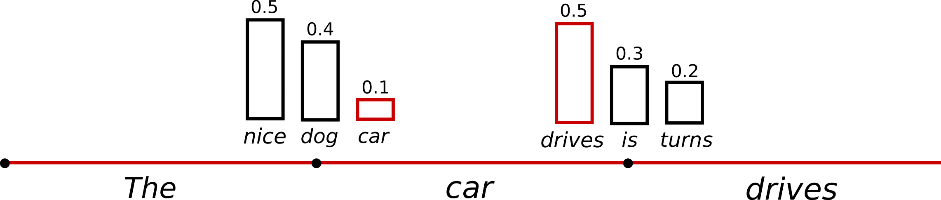

Each dot here represents a timestamp in decoding. To choose the second token **car** we randomly pick a token among [**nice**, **dog**, **car**]. The model then gives next possible tokens' probabilities and the generation algorithm *randomly* chooses **drives**, which happens to be the top-probability token.

However, as you can imagine, this may not create very coherent sentences. Let's try it out with GPT-2!

In [ ]:
# Tokenize the text with which we condition the generation
pretrained_input_ids = pretrained_tokenizer.encode("Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')
story_input_ids = story_tokenizer.encode("<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')

# Generate text until the output length (which includes the context length) reaches max_length or early stopping
seed = 84
torch.manual_seed(84)
sample_pretrained_output = pretrained_model.generate(
    pretrained_input_ids.to(device),
    do_sample=True,
    max_length=100,
    top_k=0
)

torch.manual_seed(84)
sample_story_output = story_model.generate(
    story_input_ids.to(device),
    do_sample=True,
    max_length=100,
    top_k=0
)

# Decode the output back into readable strings
display_outputs(sample_pretrained_output, sample_story_output)

--------------------------------------------------------------------------------
Pretrained model output:
--------------------------------------------------------------------------------
Bella couldn't take it anymore. Edward was gone for 3 months now and Bella was going to leave for Ibiza with Vacuo. Navigation was difficult now.

But no problems. Performing under amazing circumstances, getting to a cocaine deal, driving around ingeniously looking for money around a pawn shop and getting a paying party. Thankfully we found our way to the lady's hotel to start a stream of sex tracks and was escorted back to Nyanari. At the moment, I'm
--------------------------------------------------------------------------------
Story model output:
--------------------------------------------------------------------------------
<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and Bella decided to rewrite himself for a new life. In the meantime, her fiancé Julian became ill a

As expected the model repeats subsequences much less, but the output is incoherent due to the way we are randomly sampling from the **complete** output distribution.

### Top-$p$ (nucleus)

In class, we went over top-$p$ sampling (or also commonly referred to as nucleus sampling). The "thresholding" aspect of this algorithm is the cumulative probability mass, which is distributed among the top-$p$ answers that the algorithm can randomly choose from. This way the number of best $k$ tokens dynamically changes according to the model's confidence. Let's see how we can implement it with the *transformers* package. There are 2 types of arguments that we can pass to the model's *generate* function:
1. *top_k* : the top $k$ highest probability tokens kept for sampling
2. *top_p* : the cumulative probability mass from which the most likely words are sampled, if set to float < 1, only the smallest set of most probable tokens with probabilities that add up to $p$ **or higher** are kept for sampling.
    - **Or higher** because if no single token falls under this cumulative probability mass, for example, one token has a probability mass higher than *top_p*, then the default in huggingface is to greedily sample the top-scoring token.
    - However, you can imagine setting a minimum *top_k* such that if no token is in this cumulative probability mass, and getting further creative with such edge cases!

We set *top_k*=0 to only demonstrate nucleus sampling with *top_p*=0.7.

In [ ]:
# Tokenize the text with which we condition the generation
pretrained_input_ids = pretrained_tokenizer.encode("Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')
story_input_ids = story_tokenizer.encode("<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')

# Generate text until the output length (which includes the context length) reaches max_length or early stopping
seed = 84
torch.manual_seed(84)
sample_pretrained_output = pretrained_model.generate(
    pretrained_input_ids.to(device),
    do_sample=True,
    max_length=100,
    top_p=0.7, # sample only from tokens falling in the top cumulative 70% probability
    top_k=0 # deactivate top_k sampling
)

torch.manual_seed(84)
sample_story_output = story_model.generate(
    story_input_ids.to(device),
    do_sample=True,
    max_length=100,
    top_p=0.7, # sample only from tokens falling in the top cumulative 70% probability
    top_k=0 # deactivate top_k sampling
)

# Decode the output back into readable strings
display_outputs(sample_pretrained_output, sample_story_output)

--------------------------------------------------------------------------------
Pretrained model output:
--------------------------------------------------------------------------------
Bella couldn't take it anymore. Edward was gone for 3 months now and Bella was going to leave for a month with us. The problem was, Bella had passed away from her long illness, so we needed a cure.

The best part about our decision was that Bella was living a happy life and was doing amazing things. We knew that our beautiful child was going to be able to cope with our little world and was already learning how to live in our own world. We are so
--------------------------------------------------------------------------------
Story model output:
--------------------------------------------------------------------------------
<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and Bella decided to make a new life for herself. In the meantime, her fiancé Julian had taken the long jo

The coherence is somewhat better with respect to the context given! But what about variance?

In [ ]:
# Tokenize the text with which we condition the generation
pretrained_input_ids = pretrained_tokenizer.encode("Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')
story_input_ids = story_tokenizer.encode("<romance> Bella couldn't take it anymore. Edward was gone for 3 months now and", return_tensors='pt')

# Generate text until the output length (which includes the context length) reaches max_length or early stopping
seed = 84
torch.manual_seed(84)
sample_pretrained_output = pretrained_model.generate(
    pretrained_input_ids.to(device),
    do_sample=True,
    max_length=100,
    top_p=0.7, # sample only from tokens falling in the top cumulative 70% probability
    top_k=0, # deactivate top_k sampling
    num_return_sequences=3 # set num_return_sequences = 3
)

torch.manual_seed(84)
sample_story_output = story_model.generate(
    story_input_ids.to(device),
    do_sample=True,
    max_length=100,
    top_p=0.7, # sample only from tokens falling in the top cumulative 70% probability
    top_k=0, # deactivate top_k sampling
    num_return_sequences=3 # set num_return_sequences = 3
)

# Decode the output back into readable strings
display_outputs(sample_pretrained_output, sample_story_output, multiple_output=True)

As we somewhat expected, the outputs are much more diverse than those of deterministic decoding algorithms. And it looks like Bella does not get a happy ending if *num_return_sequences*=3 🥲 even if all three endings are unique in their own way.

Sampling can be really finicky according to the input text we condition our generation with and the top-$k$ or top-$p$ hyperparameter options we choose.

However, it offers a wider variety of outputs rather than decoding algorithms like greedy and beam search.